In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


damn that big X is looking even more swastika-like today

[Animals eating noodles](https://twitter.com/_akhaliq/status/1812573686152450397) - X (formerly Twitter)

___

If the shooter had a proper self-directed facial recognition AI robot gun or an autonomous killer drone he wouldn't have missed.

[AI and tech are reshaping warfare.](https://www.axios.com/2024/07/10/us-military-future-weapons-ai-warfare)

___

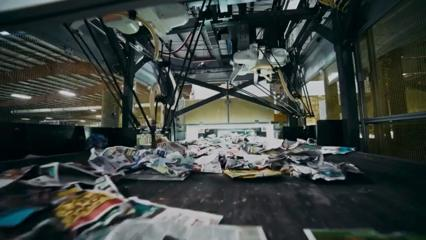

[AI trash sorting. I honestly need an AI app to figure out what to do with different types of trash. I fail  at the Turing Test of, is this Whole Foods carton compost, too dirty for paper bin?](https://www.13newsnow.com/article/news/local/mycity/portsmouth/artificial-intelligence-is-changing-how-the-city-of-portsmouth-recycles/291-770d039e-f053-4336-a9db-cc2e495abbf9) - 13newsnow.com

___

[A beginners' guide to quantization.](https://www.theregister.com/2024/07/14/quantization_llm_feature/)

___

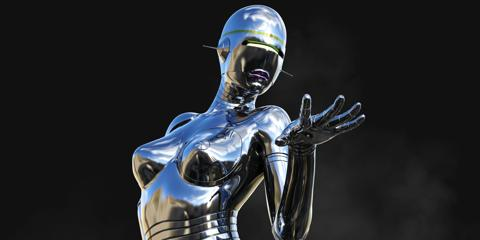

[AskMen survey says everyone is sexting with AI but finding a real person to sext with is proposed as better for both one's sex life and the environment.](https://www.askmen.com/news/dating-news/survey-finds-huge-percentage-of-people-sexting-with-ai.html) - AskMen

___

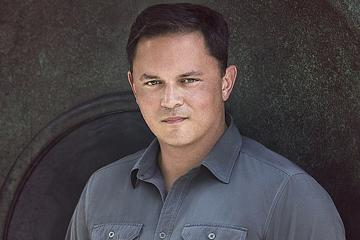

[AI and killer robots figure in new 'Gray Man' novel.](https://www.timesfreepress.com/news/2024/jul/13/review-mark-greaneys-gray-man-tackles-a-new-foe/)

___

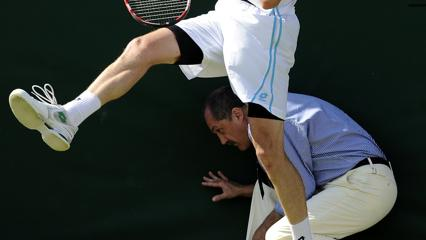

[Wimbledon line judges might be replaced by AI, Djokovic says it's time.](https://www.dailymail.co.uk/news/article-13631915/Wimbledon-line-judges-fear-usurped-artificial-intelligence-SW19-French-Open-two-grand-slam-tournaments-adopt-electronic-line-calling-system.html) - Mail Online

___

[Using LMSYS type Chatbot Arena battles to train and improve chatbots.](https://www.microsoft.com/en-us/research/publication/arena-learning-build-data-flywheel-for-llms-post-training-via-simulated-chatbot-arena/)

___

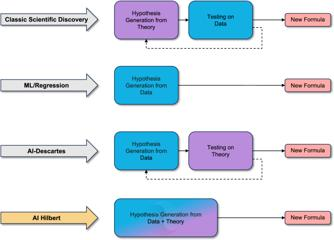

[Open source AI Hilbert combines data and theory to formulate testable hypotheses and advance science - ai-hilbert.github.io](https://www.nature.com/articles/s41467-024-50074-w) - Nature

___

[How Microsoft’s Satya Nadella Became Tech’s Steely Eyed A.I. Gambler](https://www.nytimes.com/2024/07/14/technology/microsoft-ai-satya-nadella.html)

___

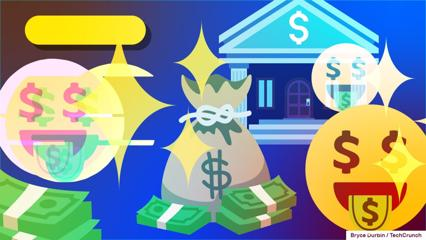

[28 AI startups that raised over \\$100m this year.](https://techcrunch.com/2024/07/13/heres-the-full-list-of-28-us-ai-startups-that-have-raised-100m-or-more-in-2024/) - TechCrunch

___

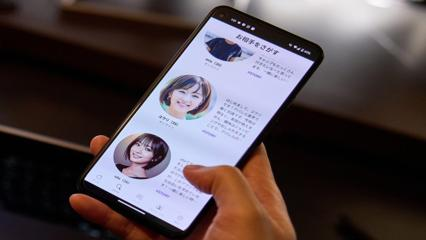

[Loverse AI dating experience app gains popularity in Japan.](https://interestingengineering.com/culture/japan-ai-dating-app-bot-partners) - Interesting Engineering

___

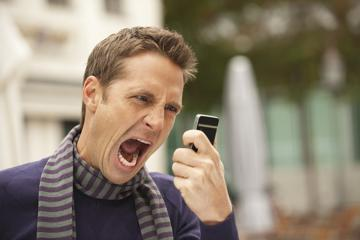

[Surveys say people hate AI customer service.](https://futurism.com/the-byte/people-hate-ai-customer-service) - Futurism

___

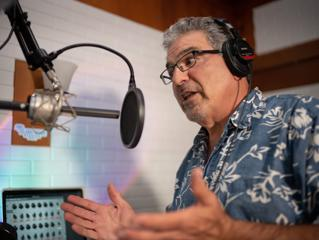

["In a world where AI has replaced voice-over artists like 'voice of God' Don LaFontaine ..."](https://lookout.co/artificial-intelligence-ai-dean-compoginis-voice-over-artist-sounds-alarm/) - Lookout Santa Cruz

___

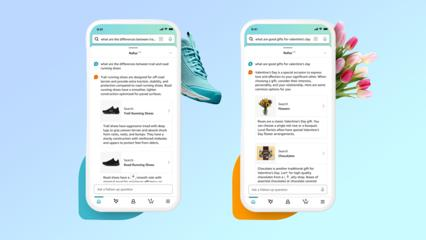

[Amazon's Rufus chatbot is here for Prime Day, reviews say it's OK.](https://www.tomsguide.com/ai/amazons-ai-chatbot-is-here-to-make-prime-day-shopping-easier) - Tom's Guide

___

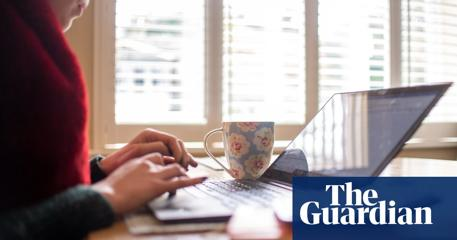

[AI can boost individual writers' creativity while reducing overall novelty and making all writers sound more similar.](https://www.theguardian.com/technology/article/2024/jul/12/ai-prompts-can-boost-writers-creativity-but-result-in-similar-stories-study-finds) - the Guardian

___

Biden be like, damn I can’t catch a break. Why can’t I get grazed in an ear or if they’re gonna shoot at TFG then why can’t they shoot straight? Why do I go to church like every single day? and this is what I get? Why does God hate me so much?

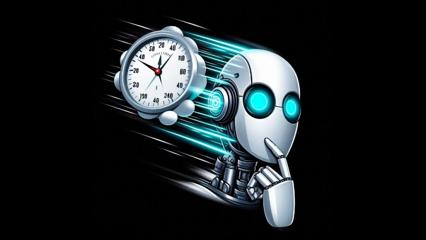

[It feels like LLMs are the fast 'system 1' in Kahneman's 'Thinking Fast and Slow' and the planning and reasoning is the slow 'system 2', and there is this natural dichotomy between the 2, between poets and quants.](https://venturebeat.com/ai/meta-researchers-distill-system-2-thinking-into-llms-improving-performance-on-complex-reasoning/) - VentureBeat

___

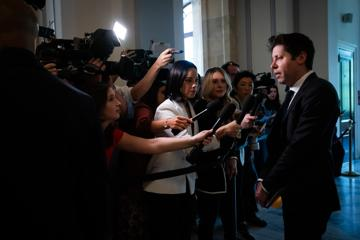

[Whistleblowers say OpenAI illegally barred staffers from whistleblowing.](https://www.washingtonpost.com/technology/2024/07/13/openai-safety-risks-whistleblower-sec/) - Washington Post

___

[Looks like maybe OpenAI is doing a small model or something.](https://x.com/apples_jimmy/status/1812029979888439525) - X (formerly Twitter)

___

A problem in the bullish iPhone thesis is, they will announce in the fall but the AI features might not be available until the spring, by which time 2026 iPhones are 6 months away.

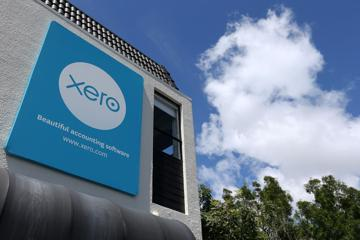

[AI is coming for accounting and financial management but maybe not yet.](https://www.forbes.com/sites/quickerbettertech/2024/07/12/how-intuit-xero-sage-and-sap-are-positioning-ai-to-change-your-accounting-department/) - Forbes

___

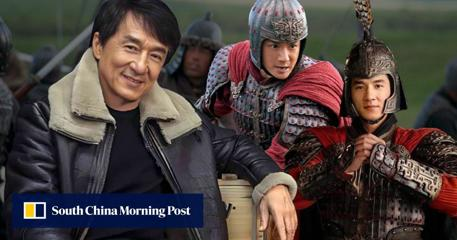

[China audiences mock AI rejuvenation of Jackie Chan.](https://www.scmp.com/news/people-culture/china-personalities/article/3270226/china-critics-pan-ai-rejuvenation-jackie-chan-new-film-legend) - South China Morning Post

___

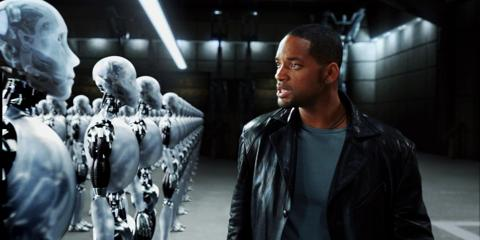

[Is the AI bubble about to burst in Hollywood? I think some uses of AI are like 3D TVs and make things no better and possibly worse, and you have to stay human-centered. On the whole though, giving computers the power of natural language understanding and human speech is kind of a big deal.](https://nofilmschool.com/ai-bubble-burst) - No Film School

___

So they walk on in silence for a bit, and then the 2nd says, you know I feel like we each ate a turd for no reason, and neither of us have more money than we started with? And the 1st says, that's true, but we raised the GDP by $200!

A GDP joke: 2 economists are walking along and the 1st says to the 2nd, I'll pay you $100 if you eat that turd over there. The 2nd laughs and eats the turd and gets the $100. A little while later the 2nd sees another turd, and says to the 1st, ha I'll pay you $100 to eat that one, and he does.

[Acemoglu's skepticism about the GDP impact.](https://www.nytimes.com/2024/07/13/business/dealbook/what-if-the-ai-boosters-are-wrong.html)

___

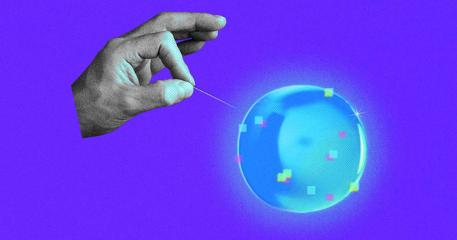

[AI skepticism is on the rise. I think there's a strain that says AI hype is way overblown (true) and there will be financial failures (true) and there's a strain of AI-haters who say it's useless and a nothingburger (false).](https://www.emergingtechbrew.com/stories/2024/07/10/investor-concern-ai-bubble) - Tech Brew

___

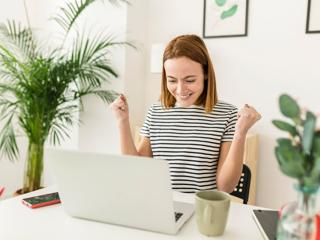

[Use AI to generate a full-blown excuse narrative no one can poke holes in.](https://www.forbes.com/sites/lanceeliot/2024/07/13/the-sun-was-in-my-eyes-and-other-sorry-excuses-are-being-polished-and-perfected-via-use-of-generative-ai/) - Forbes

___

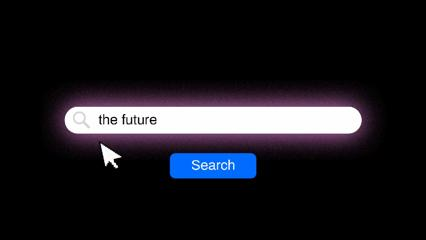

[Perplexity and RAG and the evolution of search. It seems like Google fixed a lot of their AI Overview issues by downgrading Quora and Reddit and reducing the number of queries that get AI overviews.](https://www.freethink.com/robots-ai/ai-search-engines-llms) - Freethink

___

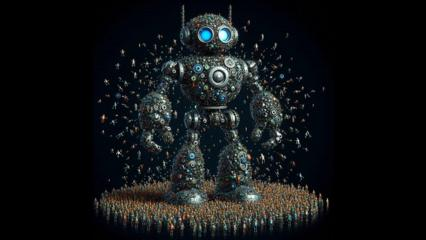

[Google research scales mixture of experts models to millions of small models that can do different things well.](https://venturebeat.com/ai/deepminds-peer-scales-language-models-with-millions-of-tiny-experts/) - VentureBeat

___

[AI improves predictions of Alzheimer's progress.](https://medicalxpress.com/news/2024-07-artificial-intelligence-outperforms-clinical-alzheimer.html)

___

[AI shown to successfully predict prostate cancer recurrence.](https://medicalxpress.com/news/2024-07-tool-combines-evolution-ai-prostate.html)

___

[Details of OpenAI 'Strawberry' a/k/a Q* leak (from a former employee sounds like), may have been demoed to a large group internally last week with much improved planning, reasoning, logical, problem-solving capabilities.](https://www.reuters.com/technology/artificial-intelligence/openai-working-new-reasoning-technology-under-code-name-strawberry-2024-07-12/)

___

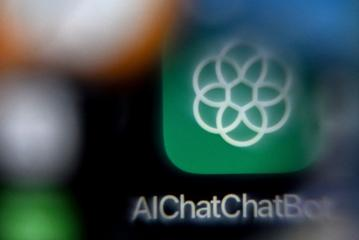

[Many people think AI has some form of conscious experience.](https://www.techtimes.com/articles/306299/20240703/ai-tools-chatgpt-conscious-what-new-study.htm) - Tech Times

___

[Meta reportedly plans to release a 405b-parameter open source Llama 3 model on July 23](https://www.theinformation.com/briefings/meta-platforms-to-release-largest-llama-3-model-on-july-23)

___

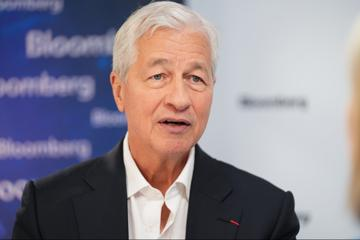

[Jamie Dimon is super pumped about AI.](https://www.entrepreneur.com/business-news/ceo-jamie-dimon-how-jpmorgan-chase-uses-ai-in-the-workplace/477036) - Entrepreneur

___

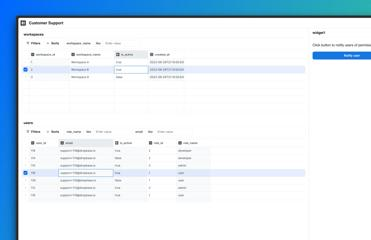

[Dropbase is a prompt-based Web app builder.](https://www.dropbase.io/)

___

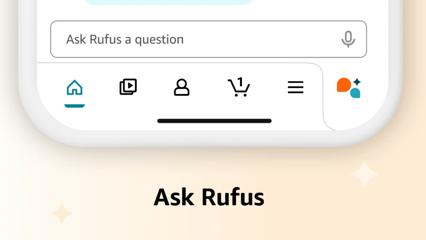

[Rufus, Amazon's shopping assistant chatbot, now live for all US customers in the mobile app.](https://techcrunch.com/2024/07/12/amazon-ai-chatbot-rufus-is-now-live-for-all-u-s-customers/) - TechCrunch

___

A popular AI undress/nudifying service on Telegram is now offering AI powered geolocations on your 'crush's' images.
They are using GeoSpyAi's service. Regardless of how accurate the geolocations are, this is another way to threaten women's safety online.

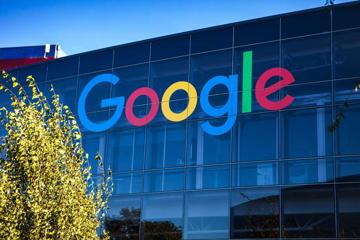

[Gemini 2m-token-context model reaches general availability.](https://www.infoworld.com/article/2510442/google-opens-access-to-2-million-context-window-of-gemini-1-5-pro.html) - InfoWorld

___

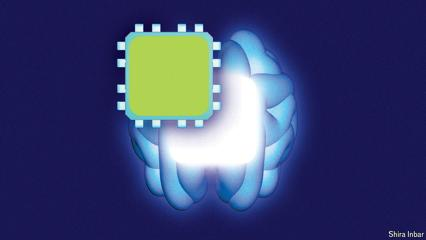

[Nobody knows how LLMs work but some people are trying to figure it out.](https://www.economist.com/science-and-technology/2024/07/11/researchers-are-figuring-out-how-large-language-models-work) - The Economist

___

[Academia is vastly outgunned by Big Tech on compute-intensive research.](https://www.wsj.com/articles/universities-dont-want-ai-research-to-leave-them-behind-20318395)

___

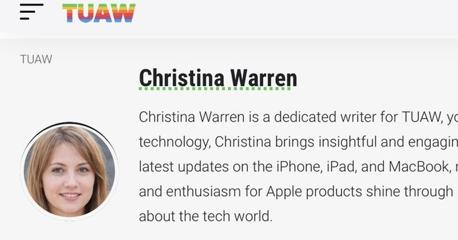

[AI slop devours the late lamented TUAW blog, which now publishes AI-generated content under the real names of real former writers who are no longer associated with the site. Seems pretty straight fraud to claim a real person wrote stuff which they didn't, for clicks and money.](https://www.theverge.com/2024/7/10/24195858/tuaw-unofficial-apple-tech-blog-ai-web-orange-khan) - The Verge

___

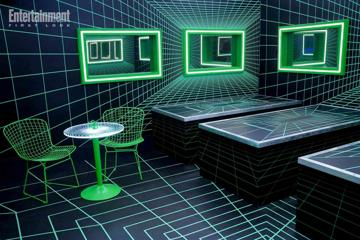

[AI is in the house for latest season of Big Brother. I'm not sure what I just read, but I think they are going with an AI theme and had AI design the ugliest house possible.](https://ew.com/big-brother-26-house-photos-first-look-exclusive-8675004) - EW.com

___

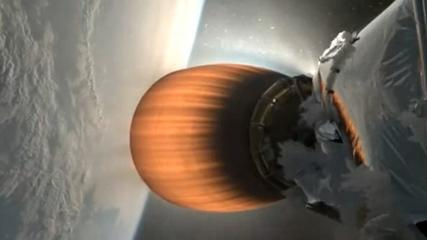

[Falcon rocket fails for the first time in years. Its creator is a wanker but he has ushered in an era of much safer, cheaper trips into low-earth-orbit.](https://gizmodo.com/spacexs-falcon-9-grounded-after-second-stage-breaks-apart-in-space-2000469770) - Gizmodo

___

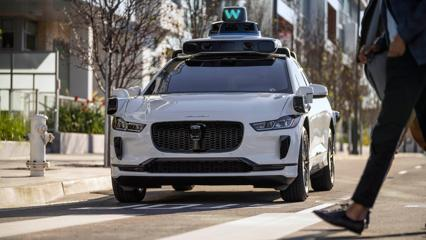

[Serial robotaxi tire slasher busted.](https://gizmodo.com/san-francisco-man-accused-of-slashing-the-tires-on-17-waymo-robotaxis-2000469566) - Gizmodo

___

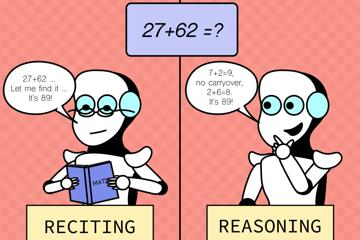

[Reasoning skills of large language models are often overestimated, they can't reason from first principles or extrapolate much beyond circumstances encountered in training](https://news.mit.edu/2024/reasoning-skills-large-language-models-often-overestimated-0711) - MIT News | Massachusetts Institute of Technology

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 14, 20, 24, 39, 502000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-13 10:26:40.825137


In [13]:
sqlite

NameError: name 'sqlite' is not defined